# Predicting House Prices
We’ll attempt to predict the median price of homes in a given Boston
suburb in the mid-1970s, given data points about the suburb at the time,
such as the crime rate, the local property tax rate, and so on.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

### Loading the dataset

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

We have a very small dataset here. Only 404 training samples and 102 test samples. Also, each feature in the input data (for example, the crime rate) has a different scale.

### Preparing the data

It would be problematic to feed into a neural network values that all take
wildly different ranges. The network might be able to automatically adapt
to such heterogeneous data, but it would definitely make learning more
difficult. A widespread best practice to deal with such data is to do featurewise
normalization: for each feature in the input data we apply $Z=\frac{X-\mu}{\sigma}$ so that $ X\sim N(0,1)$. 

In [5]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your network
Because so few samples are available, we’ll use a very small network with
two hidden layers, each with 64 units. In general, the less training data you
have, the worse overfitting will be, and using a small network is one way to
mitigate overfitting.

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                                    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# Since we’ll need to instantiate the same model multiple times, you use a function to construct it.

The network ends with a single unit and no activation (it will be a linear
layer). This is a typical setup for scalar regression. Applying an activation
function would constrain the range the output can take; for instance, if you
applied a sigmoid activation function to the last layer, the network could
only learn to predict values between 0 and 1. Here, because the last layer is
purely linear, the network is free to learn to predict values in any range. We compile the network with the mse loss function—mean squared error.
We’re also monitoring a new metric during training: mean absolute
error (MAE). It’s the absolute value of the difference between the
predictions and the targets. For instance, an MAE of 0.5 on this problem
would mean our predictions are off by $500 on average.

### Validating our approach using k-fold validation

The k-fold cross-validation consists of splitting the available data into K partitions
(typically K = 4 or 5), instantiating K identical models, and training each
one on K – 1 partitions while evaluating on the remaining partition. The
validation score for the model used is then the average of the K validation
scores obtained.

In [7]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
                           [train_data[:i * num_val_samples],
                           train_data[(i + 1) * num_val_samples:]],
                           axis=0)
    partial_train_targets = np.concatenate(
                                  [train_targets[:i * num_val_samples],
                                 train_targets[(i + 1) * num_val_samples:]],
                                  axis=0)
    model = build_model() 
    model.fit(partial_train_data, partial_train_targets, 
                           epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
all_scores

[2.1686105728149414, 2.442441463470459, 2.7229197025299072, 2.6289732456207275]

In [9]:
np.mean(all_scores)

2.490736246109009

The different runs do indeed show rather different validation scores, from
2.0 to 2.8. The average (2.5) is a much more reliable metric than any single
score—that’s the entire point of K-fold cross-validation. In this case, we’re
off by $\$ 2,500$ on average, which is significant considering that the prices
range from $\$10,000$ to $\$50,000$.

Let’s try training the network a bit longer: 500 epochs. To keep a record of
how well the model does at each epoch, we’ll modify the training loop to
save the per-epoch validation score log.

In [10]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( 
                             [train_data[:i * num_val_samples],
                              train_data[(i + 1) * num_val_samples:]],
                              axis=0)
    partial_train_targets = np.concatenate(
                                  [train_targets[:i * num_val_samples],
                                   train_targets[(i + 1) * num_val_samples:]],
                                   axis=0)
    model = build_model() 
    history = model.fit(partial_train_data, partial_train_targets, 
                              validation_data=(val_data, val_targets),
                                epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae'] #'val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
# We can then compute the average of the per-epoch MAE scores for all folds.

average_mae_history =[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

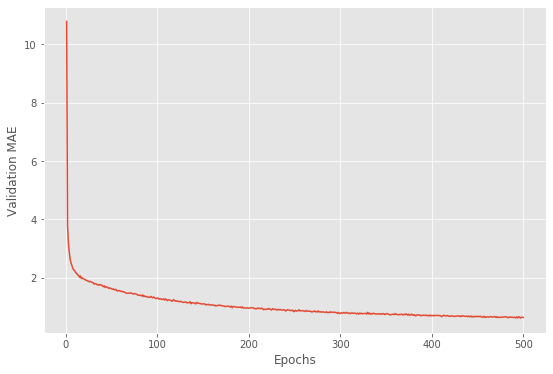

In [13]:
#Plotting the validation score

plt.figure(figsize=(9,6))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It is a little difficult to see the plot, due to scaling issues and relatively
high variance. Let’s do the following:
1. Omit the first 10 data points, which are on a different scale than the rest of the curve.
2. Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

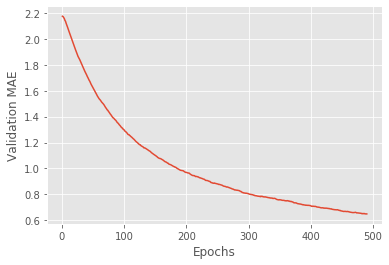

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE improves as the epochs increases.

In [15]:
# We can train a final production model on all of the training data, with the
# best parameters, and then look at its performance on the test data.

model = build_model()
model.fit(train_data, train_targets,
               epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 713us/step


In [16]:
test_mae_score

2.982508420944214

Notice, we are still off by about $\$3,000$.